In [1]:
import os
import time
import numpy as np
# import tensorflow as tf
from glob import glob
import cv2

from config import Parameters
# from processors import SimpleDataGenerator
from custom_processors import AnalyseCustomDataGenerator
from det3d.pc_kitti_dataset import PCKittiAugmentedDataset

import matplotlib.pyplot as plt

In [2]:

# DATA_ROOT = "/media/data3/tjtanaa/kitti_dataset/KITTI/object/training"  # TODO make main arg
DATA_ROOT = "/media/data3/tjtanaa/kitti_dataset/"  # TODO make main arg
MODEL_ROOT = "./logs_Car_Pedestrian_Custom_Dataset_single_process"

In [3]:
params = Parameters()

gt_database_dir = os.path.join(DATA_ROOT, "gt_database")

training_gen = AnalyseCustomDataGenerator(batch_size=params.batch_size,root_dir = DATA_ROOT,
                npoints=20000, split='train',   classes=list(params.classes_map.keys()), 
                random_select=False, gt_database_dir=None, aug_hard_ratio=0.7)

validation_gen = AnalyseCustomDataGenerator(batch_size=params.batch_size,  root_dir=DATA_ROOT, 
        npoints=20000, split='val',  random_select=False, classes=list(params.classes_map.keys()))

# # get the min and max (range) of every axis
# x_max = np.array(-9999.0)
# x_min = np.array(9999.0)
# y_max = np.array(-9999.0)
# y_min = np.array(9999.0)
# z_max = np.array(-9999.0)
# z_min = np.array(9999.0)
# for i in range(len(training_gen)):
#     [pillars, voxels], \
#     [occupancy, position, size, angle, heading, classification], \
#     [pts_input, gt_boxes3d, sample] = training_gen[i]
#     for pts in pts_input:
# #         print(type(pts))
# #         print(pts.shape)
#         x_max = np.max([x_max, np.max(pts[:,0])])
#         x_min = np.min([x_min, np.min(pts[:,0])])
#         y_max = np.max([y_max, np.max(pts[:,1])])
#         y_min = np.min([y_min, np.min(pts[:,1])])
#         z_max = np.max([z_max, np.max(pts[:,2])])
#         z_min = np.min([z_min, np.min(pts[:,2])])
# print(x_min, x_max)
# print(y_min, y_max)
# print(z_min, z_max)
# 1.349664568901062 78.88325500488281
# -52.52265167236328 50.9976806640625
# -1.0496952533721924 3.1484153270721436
    

36
37
38
39


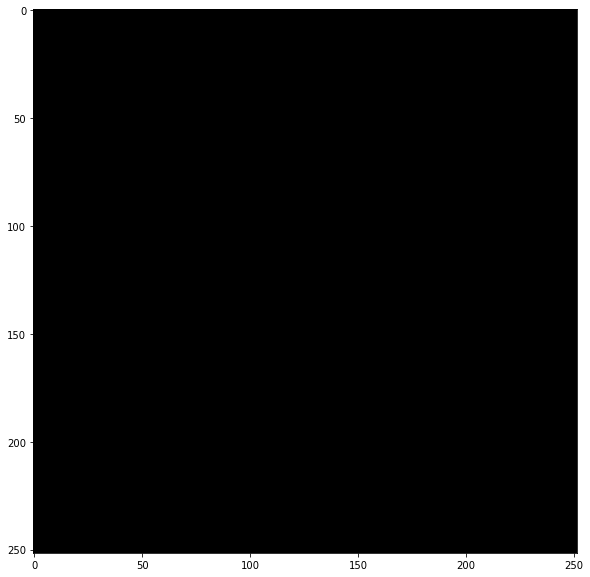

In [4]:

[pillars, voxels], \
[occupancy, position, size, angle, heading, classification], \
[pts_input, gt_boxes3d, sample] = validation_gen[9]
# print(pillars[0].shape)
# print(voxels[0].shape)
# print(occupancy[0].shape)
# # print(occupancy[0,0,:])
# print(angle[0].shape)

# for i in range(len(occupancy)):
#     print(i, "l ")
#     print(np.sum(occupancy[i][:,:,0] == 0))
#     print(np.sum(occupancy[i][:,:,0] == 1))
#     print(np.sum(occupancy[i][:,:,0] == -1))
#     print(np.sum(occupancy[i][:,:,1] == 0))
#     print(np.sum(occupancy[i][:,:,1] == 1))
#     print(np.sum(occupancy[i][:,:,1] == -1))
#     print(np.sum(occupancy[i][:,:,2] == 0))
#     print(np.sum(occupancy[i][:,:,2] == 1))
#     print(np.sum(occupancy[i][:,:,2] == -1))
#     print(np.sum(occupancy[i][:,:,3] == 0))
#     print(np.sum(occupancy[i][:,:,3] == 1))
#     print(np.sum(occupancy[i][:,:,3] == -1))


fig = plt.figure(figsize=(10,10)) 
  
ax = fig.add_subplot(111) 
ax.imshow(occupancy[0][:,:,3] == 1, cmap = plt.cm.gray, 
          interpolation ='nearest') 

In [7]:

import numba

[pillars, voxels], \
[occupancy, position, size, angle, heading, classification], \
[pts_input, gt_boxes3d, sample] = validation_gen[8]


@numba.jit(nopython=True)
def _points_to_bevmap_reverse_kernel(
        points,
        voxel_size,
        coors_range,
        coor_to_voxelidx,
        # coors_2d,
        bev_map,
        height_lowers,
        # density_norm_num=16,
        with_reflectivity=False,
        max_voxels=40000):
    # put all computations to one loop.
    # we shouldn't create large array in main jit code, otherwise
    # reduce performance
    N = points.shape[0]
    ndim = 3
    ndim_minus_1 = ndim - 1
    grid_size = (coors_range[3:] - coors_range[:3]) / voxel_size
    # np.round(grid_size)
    # grid_size = np.round(grid_size).astype(np.int64)(np.int32)
    grid_size = np.round(grid_size, 0, grid_size).astype(np.int32)
    height_slice_size = voxel_size[-1]
    coor = np.zeros(shape=(3, ), dtype=np.int32)  # DHW
    voxel_num = 0
    failed = False
    for i in range(N):
        failed = False
        for j in range(ndim):
            c = np.floor((points[i, j] - coors_range[j]) / voxel_size[j])
            if c < 0 or c >= grid_size[j]:
                failed = True
                break
            coor[ndim_minus_1 - j] = c
        if failed:
            continue
        voxelidx = coor_to_voxelidx[coor[0], coor[1], coor[2]]
        if voxelidx == -1:
            voxelidx = voxel_num
            if voxel_num >= max_voxels:
                break
            voxel_num += 1
            coor_to_voxelidx[coor[0], coor[1], coor[2]] = voxelidx
            # coors_2d[voxelidx] = coor[1:]
        bev_map[-1, coor[1], coor[2]] += 1
        height_norm = bev_map[coor[0], coor[1], coor[2]]
        incomimg_height_norm = (
            points[i, 2] - height_lowers[coor[0]]) / height_slice_size
        if incomimg_height_norm > height_norm:
            bev_map[coor[0], coor[1], coor[2]] = incomimg_height_norm
            if with_reflectivity:
                bev_map[-2, coor[1], coor[2]] = points[i, 3]
    # return voxel_num

def points_to_bev(points,
                  voxel_size,
                  coors_range,
                  with_reflectivity=False,
                  density_norm_num=16,
                  max_voxels=40000):
    """convert kitti points(N, 4) to a bev map. return [C, H, W] map.
    this function based on algorithm in points_to_voxel.
    takes 5ms in a reduced pointcloud with voxel_size=[0.1, 0.1, 0.8]

    Args:
        points: [N, ndim] float tensor. points[:, :3] contain xyz points and
            points[:, 3] contain reflectivity.
        voxel_size: [3] list/tuple or array, float. xyz, indicate voxel size
        coors_range: [6] list/tuple or array, float. indicate voxel range.
            format: xyzxyz, minmax
        with_reflectivity: bool. if True, will add a intensity map to bev map.
    Returns:
        bev_map: [num_height_maps + 1(2), H, W] float tensor. 
            `WARNING`: bev_map[-1] is num_points map, NOT density map, 
            because calculate density map need more time in cpu rather than gpu. 
            if with_reflectivity is True, bev_map[-2] is intensity map. 
    """
    if not isinstance(voxel_size, np.ndarray):
        voxel_size = np.array(voxel_size, dtype=points.dtype)
    if not isinstance(coors_range, np.ndarray):
        coors_range = np.array(coors_range, dtype=points.dtype)
    voxelmap_shape = (coors_range[3:] - coors_range[:3]) / voxel_size
    voxelmap_shape = tuple(np.round(voxelmap_shape).astype(np.int32).tolist())
    voxelmap_shape = voxelmap_shape[::-1]  # DHW format
    coor_to_voxelidx = -np.ones(shape=voxelmap_shape, dtype=np.int32)
    # coors_2d = np.zeros(shape=(max_voxels, 2), dtype=np.int32)
    bev_map_shape = list(voxelmap_shape)
    bev_map_shape[0] += 1
    height_lowers = np.linspace(
        coors_range[2], coors_range[5], voxelmap_shape[0], endpoint=False)
    if with_reflectivity:
        bev_map_shape[0] += 1
    bev_map = np.zeros(shape=bev_map_shape, dtype=points.dtype)
    _points_to_bevmap_reverse_kernel(points, voxel_size, coors_range,
                                     coor_to_voxelidx, bev_map, height_lowers,
                                     with_reflectivity, max_voxels)
    # print(voxel_num)
    return bev_map

def point_to_vis_bev(points,
                     voxel_size=None,
                     coors_range=None,
                     max_voxels=80000):
    if voxel_size is None:
        voxel_size = [0.1, 0.1, 0.1]
    if coors_range is None:
        coors_range = [-50, -50, -3, 50, 50, 1]
    voxel_size[2] = coors_range[5] - coors_range[2]
    bev_map = points_to_bev(
        points, voxel_size, coors_range, max_voxels=max_voxels)
    height_map = (bev_map[0] * 255).astype(np.uint8)
    return cv2.cvtColor(height_map, cv2.COLOR_GRAY2RGB)

img = point_to_vis_bev(pts_input[0], voxel_size=[params.x_step/2, params.y_step/2, 0.01],
                       coors_range=[params.x_min, params.y_min+20.32, params.z_min, 
                                    params.x_max-40.32, params.y_max-20.32, params.z_max] )
                       

32
33
34
35


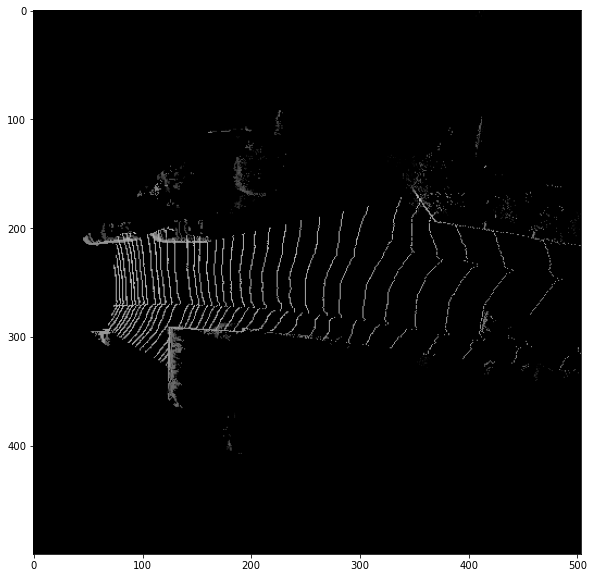

In [6]:
fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(111)
plt.imshow(img)